In [1]:
import pandas as pd
from collections import Counter

df = pd.read_csv("escalation_segments_with_context.csv")
df['startTime'] = pd.to_datetime(df['startTime'])
df['endTime'] = pd.to_datetime(df['endTime'])

### Filter by Target IP

In [11]:
target_ip = "34.68.34.64"
df_ip = df[df['clientIP'] == target_ip].sort_values('startTime')

In [12]:
for _, row in df_ip.iterrows():
    print(f"{row['from']} → {row['to']}: {row['startTime']} to {row['endTime']} ({row['duration_min']} min)")


attempt → intrusion-control: 2025-03-16 06:37:06.580137738+00:00 to 2025-03-16 06:56:02.853104684+00:00 (18.94 min)
intrusion-control → scan: 2025-03-16 06:56:02.853104684+00:00 to 2025-03-16 06:56:09.289258979+00:00 (0.11 min)
scan → attempt: 2025-03-16 06:56:09.289258979+00:00 to 2025-03-16 10:02:17.087300345+00:00 (186.13 min)
attempt → scan: 2025-03-16 10:02:17.087300345+00:00 to 2025-03-16 10:11:39.765944856+00:00 (9.38 min)
scan → attempt: 2025-03-16 11:14:58.825080332+00:00 to 2025-03-17 10:28:05.625577740+00:00 (1393.11 min)
attempt → scan: 2025-03-17 10:28:05.625577740+00:00 to 2025-03-17 10:28:16.813361223+00:00 (0.19 min)
scan → attempt: 2025-03-17 13:48:06.630607903+00:00 to 2025-03-17 14:40:12.354216340+00:00 (52.1 min)
attempt → scan: 2025-03-17 14:40:12.354216340+00:00 to 2025-03-17 14:40:16.030447666+00:00 (0.06 min)
scan → attempt: 2025-03-17 18:10:31.133601386+00:00 to 2025-03-17 19:25:49.734264974+00:00 (75.31 min)
attempt → scan: 2025-03-17 19:25:49.734264974+00:00 

In [ ]:
import pandas as pd

# Load again if not yet
df = pd.read_csv("escalation_segments_with_context.csv")
df['startTime'] = pd.to_datetime(df['startTime'])
df['endTime'] = pd.to_datetime(df['endTime'])

# Filter by IP
df_ip = df[df['clientIP'] == "xx.xx.xx.xx"]

# Create transition labels
df_ip['transition'] = df_ip['from'] + " → " + df_ip['to']

# Group by transition type
summary = df_ip.groupby('transition')['duration_min'].agg(['count', 'mean', 'std']).reset_index()
summary.columns = ['Transition', 'Count', 'Average Duration (min)', 'Std Dev (min)']
summary = summary.sort_values(by='Count', ascending=False)

print(summary.to_string(index=False))


                 Transition  Count  Average Duration (min)  Std Dev (min)
             scan → attempt    163              278.280982     665.811717
             attempt → scan    157              158.177134     466.706852
   intrusion-control → scan     37              154.093784     350.020345
   scan → intrusion-control     31              315.834194     579.476185
attempt → intrusion-control     19              470.314211     880.366512
intrusion-control → attempt     13              283.450769     378.651353


/tmp/ipykernel_676444/3586112325.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ip['transition'] = df_ip['from'] + " → " + df_ip['to']


In [14]:
import pandas as pd
from datetime import timedelta

# Load the full escalation dataset
df = pd.read_csv("escalation_segments_with_context.csv")
df['startTime'] = pd.to_datetime(df['startTime'])
df['endTime'] = pd.to_datetime(df['endTime'])

# Filter for the specific IP
ip = "34.68.34.64"
df_ip = df[df['clientIP'] == ip].sort_values("startTime")

# Show earliest and latest activity
start_time = df_ip['startTime'].min()
end_time = df_ip['endTime'].max()
duration = end_time - start_time

print(f"✓ Attacker active from {start_time} to {end_time} ({duration})")


✓ Attacker active from 2025-03-16 06:37:06.580137738+00:00 to 2025-07-15 11:27:49.236065004+00:00 (121 days 04:50:42.655927266)


The attacker at IP xx.xx.xx.xx exhibits a high-frequency loop between scanning and attempting phases, with substantial variability in timing (std dev > 600 min in some cases). Occasional transitions to intrusion-control suggest sporadic exploitation efforts. The back-and-forth between phases implies a non-linear, possibly automated strategy with delayed follow-ups or jittered retry logic.

### 4. Extract and Inspect Payload Fields

In [ ]:
# === Fill NAs to avoid issues ===
df_ip['top_uris'] = df_ip['top_uris'].fillna('')
df_ip['top_bodies'] = df_ip['top_bodies'].fillna('')

# === Flatten and count URIs ===
uri_list = []
for uri_str in df_ip['top_uris']:
    uri_list.extend([u.strip() for u in uri_str.split(';') if u.strip()])
uri_counter = Counter(uri_list)
top_uris = uri_counter.most_common(10)

# === Flatten and count payload bodies ===
body_list = []
for body_str in df_ip['top_bodies']:
    body_list.extend([b.strip() for b in body_str.split(';') if b.strip()])
body_counter = Counter(body_list)
top_bodies = body_counter.most_common(10)

# === Display Results ===
print(f"Top 10 URIs for {target_ip}:")
for uri, count in top_uris:
    print(f"- {uri} ({count})")

print(f"\nTop 10 Payload Bodies for {target_ip}:")
for body, count in top_bodies:
    print(f"- {body[:100]}... ({count})")  # show 100 chars for preview

#### 5: Extract All User-Agents Seen

In [8]:
import ast
from collections import Counter

uas = df_ip['user_agent'].dropna().tolist()
# If stored as stringified lists:
flat_uas = []
for u in uas:
    try:
        flat_uas.extend(ast.literal_eval(u))
    except Exception:
        flat_uas.append(u)

ua_counts = Counter(flat_uas)
for ua, count in ua_counts.most_common():
    print(f"{ua}  →  {count} times")


Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.4896.88 Safari/537.36  →  403 times
Mozilla/5.0 (Macintosh; Intel Mac OS X 14_4_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/123.0.0.0 Safari/537.36  →  17 times


### Define classification + UA detection

In [2]:
import pandas as pd
import json
import re
import ast

# === Load Dataset and Taxonomy ===
df_ip = pd.read_csv("escalation_segments_with_context.csv")
df_ip['startTime'] = pd.to_datetime(df_ip['startTime'], errors='coerce')

with open("../fp/regtax.json", "r") as f:
    taxonomy = json.load(f)
    
def safe_literal_eval(val):
    try:
        # Only eval if it starts and ends with brackets
        if isinstance(val, str) and val.strip().startswith("[") and val.strip().endswith("]"):
            return ast.literal_eval(val)
        elif isinstance(val, str):
            return [val]  # wrap plain strings into a list
    except:
        pass
    return []



# === Classification Function ===
def classify_intrusion_row(row, taxonomy):
    hits = []
    for parent_cat, subcats in taxonomy.items():
        for subcat, config in subcats.items():
            for field in config.get("match_fields", []):
                content = str(row.get(field, "")).lower()
                for pattern in config.get("patterns", []):
                    try:
                        if re.search(pattern, content):
                            hits.append(f"{parent_cat} → {subcat}")
                            break
                    except re.error:
                        continue
    return list(set(hits)) if hits else None

# === UA Grouping Function ===
category_keywords = {
    "browser": ["mozilla", "chrome", "safari", "edge", "firefox", "opera"],
    "cli_tool": ["curl", "wget", "httpie"],
    "python_lib": ["python", "requests", "aiohttp", "urllib"],
    "scanner_bot": ["expanse", "paloalto", "scanner", "bot", "censys", "nmap", "zgrab", "modatscanner", "wpdetector", "internetmeasurement", "genomecrawler"],
    "custom_client": ["custom", "asynchttpclient", "fasthttp", "l9explore", "keydrop"]
}

def detect_ua_group(ua):
    ua = str(ua).lower()
    if ua.strip() in ["", "unknown", "nan"]:
        return ["missing"]
    matched = [cat for cat, keys in category_keywords.items() if any(k in ua for k in keys)]
    return matched if matched else ["other"]

# === Preprocess Fields ===
df_ip["ua_list"] = df_ip["user_agent"].apply(safe_literal_eval)
df_ip["http_body"] = df_ip["top_bodies"].astype(str).str.lower()
df_ip["http_uri"] = df_ip["top_uris"].astype(str).str.lower()

# === Explode and Classify ===
df_exp = df_ip.explode("ua_list").copy()
df_exp["ua_group"] = df_exp["ua_list"].apply(lambda x: detect_ua_group(x)[0] if isinstance(x, str) else "missing")
df_exp["combined_hit"] = df_exp.apply(lambda row: classify_intrusion_row(row, taxonomy), axis=1)
df_exp = df_exp.explode("combined_hit")

# === Clean Classification Output ===
df_exp["Parent"] = df_exp["combined_hit"].apply(lambda x: x.split("→")[0].strip() if isinstance(x, str) and "→" in x else "")
df_exp["Subcat"] = df_exp["combined_hit"].apply(lambda x: x.split("→")[1].strip() if isinstance(x, str) and "→" in x else "")

# === Show Top Results ===
summary = df_exp.groupby(["ua_group", "Parent", "Subcat"]).size().reset_index(name="count")
summary = summary.sort_values("count", ascending=False)
print(summary.head(10))


         ua_group                           Parent                    Subcat  \
5         browser                 Exploit Attempts  Misconfiguration Exploit   
0         browser                                                              
1         browser            Delivery / Downloader        Direct Script Drop   
12        browser       Web Shell / Payload Upload       Simple Shell Upload   
6         browser                 Exploit Attempts           REST/JSON Abuse   
8         browser  Obfuscated / Anomalous Behavior           Unknown Pattern   
7         browser                 Exploit Attempts      SQL Injection (SQLi)   
20  custom_client                 Exploit Attempts  Misconfiguration Exploit   
26          other                                                              
30          other                 Exploit Attempts  Misconfiguration Exploit   

    count  
5   24208  
0   19195  
1    9903  
12   9832  
6    6731  
8    2081  
7    1157  
20    929  
26    927  

In [40]:
import pandas as pd
import json
import re
from ast import literal_eval

# === Load Inputs ===
df_all = pd.read_csv("escalation_segments_with_context.csv")
df_all["startTime"] = pd.to_datetime(df_all["startTime"])
df_all["endTime"] = pd.to_datetime(df_all["endTime"])

with open("../fp/regtax.json", "r") as f:
    taxonomy = json.load(f)

# === Helper Functions ===
def classify_intrusion_row(row, taxonomy):
    hits = []
    for parent_cat, subcats in taxonomy.items():
        for subcat, config in subcats.items():
            for field in config.get("match_fields", []):
                content = str(row.get(field, "")).lower()
                for pattern in config.get("patterns", []):
                    try:
                        if re.search(pattern, content):
                            hits.append(f"{parent_cat} → {subcat}")
                            break
                    except re.error:
                        continue
    return list(set(hits)) if hits else None

category_keywords = {
    "browser": ["mozilla", "chrome", "safari", "edge", "firefox", "opera"],
    "cli_tool": ["curl", "wget", "httpie"],
    "python_lib": ["python", "requests", "aiohttp", "urllib"],
    "scanner_bot": ["expanse", "paloalto", "scanner", "bot", "censys", "nmap", "zgrab", "modatscanner", "wpdetector", "internetmeasurement", "genomecrawler"],
    "custom_client": ["custom", "asynchttpclient", "fasthttp", "l9explore", "keydrop"]
}

def detect_ua_group(ua):
    ua = str(ua).lower()
    if ua.strip() in ["", "unknown", "nan"]:
        return ["missing"]
    matched = [cat for cat, keys in category_keywords.items() if any(k in ua for k in keys)]
    return matched if matched else ["other"]

def safe_literal_eval(val):
    try:
        if isinstance(val, str) and val.strip().startswith("[") and val.strip().endswith("]"):
            return literal_eval(val)
        elif isinstance(val, str):
            return [val]
    except:
        pass
    return []

# === Filter for Target IP ===
target_ip = "34.68.34.64"
df_ip = df_all[df_all["clientIP"] == target_ip].copy()

# === Process UA List ===
df_ip["ua_list"] = df_ip["user_agent"].apply(safe_literal_eval)
df_ip["http_body"] = df_ip["top_bodies"].astype(str).str.lower()
df_ip["http_uri"] = df_ip["top_uris"].astype(str).str.lower()

# === Explode UA list and tag group ===
df_exp = df_ip.explode("ua_list")
df_exp["ua_group"] = df_exp["ua_list"].apply(lambda x: detect_ua_group(x)[0] if isinstance(x, str) else "missing")

# === Classify Intrusion Categories ===
df_exp["combined_hit"] = df_exp.apply(lambda row: classify_intrusion_row(row, taxonomy), axis=1)
df_exp = df_exp.explode("combined_hit").dropna(subset=["combined_hit"])

# === Safely split Parent → Subcat ===
df_exp["has_arrow"] = df_exp["combined_hit"].str.count("→") == 1
df_exp[["Parent", "Subcat"]] = df_exp["combined_hit"].where(df_exp["has_arrow"], "→ ").str.split("→", n=1, expand=True)
df_exp["Parent"] = df_exp["Parent"].str.strip()
df_exp["Subcat"] = df_exp["Subcat"].str.strip()
df_exp = df_exp.drop(columns=["has_arrow"])
# === Group and Summarize ===
summary = df_exp.groupby(["ua_group", "Parent", "Subcat"]).size().reset_index(name="count")
summary = summary.sort_values("count", ascending=False)
print(summary.head(10))

  ua_group                           Parent                    Subcat  count
0  browser            Delivery / Downloader        Direct Script Drop    225
6  browser       Web Shell / Payload Upload       Simple Shell Upload    225
5  browser  Obfuscated / Anomalous Behavior           Unknown Pattern    138
3  browser                 Exploit Attempts           REST/JSON Abuse     79
4  browser                 Exploit Attempts      SQL Injection (SQLi)     75
2  browser                 Exploit Attempts  Misconfiguration Exploit     55
1  browser                 Exploit Attempts   Denial of Service (DoS)     32


### Visualization

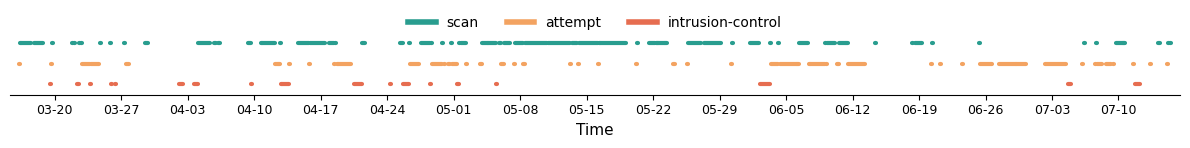

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D



# Load data
df = pd.read_csv("escalation_segments_with_context.csv")
df['startTime'] = pd.to_datetime(df['startTime'])
df['endTime'] = pd.to_datetime(df['endTime'])
df = df.sort_values(by=["clientIP", "startTime"])

sample_ip = "xx.xx.xx.xx"
df_ip = df[df['clientIP'] == sample_ip]

# Color and Y-position map
color_map = {
    'scan': ('#299d8f', 3),
    'attempt': ('#f3a361', 2),
    'intrusion-control': ('#e66d50', 1)
}


# Plot setup (unchanged)
fig, ax = plt.subplots(figsize=(12, 1.5))

for _, row in df_ip.iterrows():
    color, y_val = color_map.get(row['from'], ('gray', 0))
    ax.plot([row['startTime'], row['endTime']], [y_val, y_val],
            color=color, linewidth=3, solid_capstyle='round')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))
plt.xticks(fontsize=9)
ax.set_xlabel("Time", fontsize=11)

xmin = df_ip['startTime'].min() - pd.Timedelta(days=1)
xmax = df_ip['endTime'].max() + pd.Timedelta(days=1)
ax.set_xlim([xmin, xmax])

ax.set_yticks([])
ax.set_yticklabels([])
ax.spines[['left', 'right', 'top']].set_visible(False)
ax.set_ylim(0.5, 3.5)

# Optional title
# ax.set_title(f"Escalation Timeline for {sample_ip}", fontsize=13, pad=12)

legend_elements = [
    Line2D([0], [0], color='#299d8f', lw=4, label='scan'),
    Line2D([0], [0], color='#f3a361', lw=4, label='attempt'),
    Line2D([0], [0], color='#e66d50', lw=4, label='intrusion-control')
]
ax.legend(handles=legend_elements, loc='lower center',
          bbox_to_anchor=(0.5, 0.85), ncol=3, frameon=False, fontsize=10)

plt.tight_layout()
plt.savefig("escalation_timeline_xx.68.34.xx.pdf", bbox_inches='tight')
